###
### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_score

#
# Preperation

###
### Reading CSV with cleaned home data

In [2]:
main = pd.read_csv('data/Scraped-Cleaned-HomeData.csv')
main = main.dropna()

main = main.reset_index(drop=True)

In [3]:
main['Town/City'].value_counts()

Massapequa         242
Valley Stream      199
Westbury           155
Port Washington    151
Merrick            133
                  ... 
East Williston       9
Rosedale             4
South Hempstead      4
Amityville           3
Jamaica              1
Name: Town/City, Length: 63, dtype: int64

In [4]:
main[main['Price']==988800]

,Price,Sq Ft,Bedrooms,Full Bath,Half Bath,Property Type,Lot Size,Year Built,Town/City,Town/City Median Income
1774,988800.0,2622,4,2.0,1.0,Single Family,0.14,1998.0,Oceanside,103596
2526,988800.0,2782,5,3.0,0.0,Single Family,0.15,1954.0,Syosset,153880


###
### Here I feature engineered the average market value of the homes for each town/city

In [5]:
mhv = []

for i in main.index:
    town = main.iloc[i]['Town/City']
    avg = np.average(main[main['Town/City']== town].Price.values)
    mhv.append(avg) 

main['Median Home Value'] = mhv

###
### Price distrubution

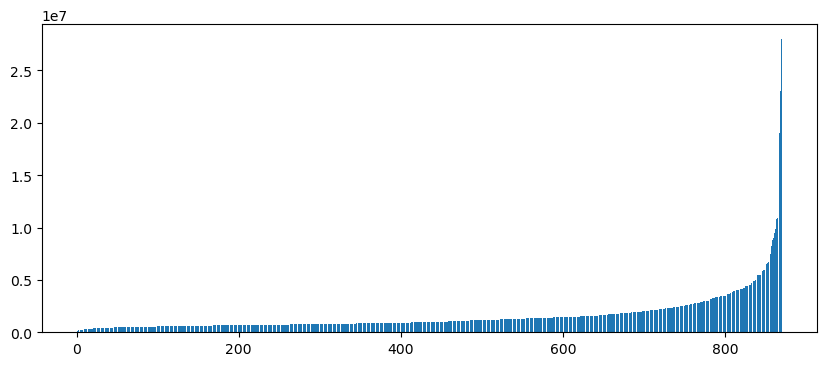

In [6]:
y = main.Price.value_counts().index.tolist()
x = [x for x in range(1, len(y)+1)]
y.sort()
x.sort()

fig = plt.figure(figsize=(10,4))
plt.bar(x, y)
plt.show()

###
### Here I removed a row with the median income as 0 and a changed a specific row's income to another value

In [7]:
outsider = main['Town/City Median Income'].value_counts().index[-1]
index = main[main['Town/City Median Income'] == outsider].index
main.loc[index, 'Town/City Median Income'] =  148988

main['Town/City Median Income'].value_counts()
townToMedian = pd.DataFrame(list(main['Town/City Median Income']), index=list(main['Town/City'])).drop_duplicates()
townToMedianHomeValue = pd.DataFrame(list(main['Median Home Value']), index=list(main['Town/City'])).drop_duplicates()
main = main.reset_index(drop=True)

outsider = main['Town/City Median Income'].value_counts().index[-1]
index = main[main['Town/City Median Income'] == outsider].index
main = main.drop(index)
main['Town/City Median Income'].value_counts()

109697    242
82417     199
94101     155
119164    151
132835    133
         ... 
118445     10
130858      9
84261       4
105456      4
80155       3
Name: Town/City Median Income, Length: 62, dtype: int64

In [8]:
main['Town/City'].value_counts()

Massapequa         242
Valley Stream      199
Westbury           155
Port Washington    151
Merrick            133
                  ... 
Massapequa Park     10
East Williston       9
Rosedale             4
South Hempstead      4
Amityville           3
Name: Town/City, Length: 62, dtype: int64

In [9]:
main['Price'].mean()

1095123.7741481273

###
### Two quick things I will do:
### First I will move a few columns around to the order that I want
### Next I will create a 'Total Baths' Column which is the sum of columns: 'Half Bath' and 'Full Bath'

In [10]:
column = main.pop('Half Bath')
main.insert(4, 'Half Bath', column)

column = main['Half Bath'] + main['Full Bath']
main.insert(5, 'Total Baths', column)

column = main.pop('Lot Size')
main.insert(6, 'Lot Size', column)

column = main.pop('Sq Ft')
main.insert(5, 'Sq Ft', column)

column = main.pop('Town/City')
main.insert(7, 'Town/City', column)

main = main[main['Property Type'] != ' Condo ']
main = main[main['Property Type'] != ' Townhouse ']
main = main[main['Property Type'] != ' Co-Op ']
main = main.reset_index(drop=True)
##
main

,Price,Bedrooms,Full Bath,Half Bath,Total Baths,Sq Ft,Lot Size,Town/City,Property Type,Year Built,Town/City Median Income,Median Home Value
0,1950000.0,5,4.0,1.0,5.0,3388,0.13,Oyster Bay,Single Family,1968.0,117085,2.163786e+06
1,995000.0,4,1.0,2.0,3.0,6192,0.14,Oyster Bay,Single Family,1903.0,117085,2.163786e+06
2,1325000.0,5,3.0,1.0,4.0,3582,0.21,Oyster Bay,Single Family,1905.0,117085,2.163786e+06
3,2395000.0,5,5.0,1.0,6.0,87338,2.01,Oyster Bay,Single Family,1984.0,117085,2.163786e+06
4,989000.0,4,3.0,1.0,4.0,14810,0.34,Oyster Bay,Multi-Family,1930.0,117085,2.163786e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
3546,5830000.0,11,8.0,1.0,9.0,14835,0.96,Lawrence,Single Family,2016.0,43244,3.066667e+06
3547,3100000.0,5,4.0,1.0,5.0,4480,0.37,Lawrence,Single Family,1959.0,43244,3.066667e+06
3548,1275000.0,4,2.0,1.0,3.0,19079,0.44,Lawrence,Single Family,1951.0,43244,3.066667e+06
3549,1850000.0,11,4.0,0.0,4.0,33706,0.77,Lawrence,Multi-Family,1900.0,43244,3.066667e+06


In [11]:
main['Property Type'].value_counts()

 Single Family     3435
 Multi-Family       116
Name: Property Type, dtype: int64

###
### Data Shape

In [12]:
main.shape

(3551, 12)

###
### I will now use OneHotEncoder to categorize: 'Property Type' and 'Town/City'

In [13]:
enc = preprocessing.OneHotEncoder(sparse_output=False)

X = [[x] for x in main['Property Type']]
categories = enc.fit_transform(X)

COLUMNS1 = list(enc.get_feature_names_out())
categories = pd.DataFrame(categories, columns=COLUMNS1)

main = main.drop('Property Type', axis=1, inplace=False).join(categories)
main

,Price,Bedrooms,Full Bath,Half Bath,Total Baths,Sq Ft,Lot Size,Town/City,Year Built,Town/City Median Income,Median Home Value,x0_ Multi-Family,x0_ Single Family
0,1950000.0,5,4.0,1.0,5.0,3388,0.13,Oyster Bay,1968.0,117085,2.163786e+06,0.0,1.0
1,995000.0,4,1.0,2.0,3.0,6192,0.14,Oyster Bay,1903.0,117085,2.163786e+06,0.0,1.0
2,1325000.0,5,3.0,1.0,4.0,3582,0.21,Oyster Bay,1905.0,117085,2.163786e+06,0.0,1.0
3,2395000.0,5,5.0,1.0,6.0,87338,2.01,Oyster Bay,1984.0,117085,2.163786e+06,0.0,1.0
4,989000.0,4,3.0,1.0,4.0,14810,0.34,Oyster Bay,1930.0,117085,2.163786e+06,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546,5830000.0,11,8.0,1.0,9.0,14835,0.96,Lawrence,2016.0,43244,3.066667e+06,0.0,1.0
3547,3100000.0,5,4.0,1.0,5.0,4480,0.37,Lawrence,1959.0,43244,3.066667e+06,0.0,1.0
3548,1275000.0,4,2.0,1.0,3.0,19079,0.44,Lawrence,1951.0,43244,3.066667e+06,0.0,1.0
3549,1850000.0,11,4.0,0.0,4.0,33706,0.77,Lawrence,1900.0,43244,3.066667e+06,1.0,0.0


In [14]:
X = [[x] for x in main['Town/City']]
categories = enc.fit_transform(X)

COLUMNS2 = list(enc.get_feature_names_out())
categories = pd.DataFrame(categories, columns=COLUMNS2)

main = main.drop('Town/City', axis=1, inplace=False).join(categories)
main.head(3)

,Price,Bedrooms,Full Bath,Half Bath,Total Baths,Sq Ft,Lot Size,Year Built,Town/City Median Income,Median Home Value,...,x0_South Hempstead,x0_Syosset,x0_Uniondale,x0_Valley Stream,x0_Wantagh,x0_West Hempstead,x0_Westbury,x0_Williston Park,x0_Woodbury,x0_Woodmere
0,1950000.0,5,4.0,1.0,5.0,3388,0.13,1968.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,995000.0,4,1.0,2.0,3.0,6192,0.14,1903.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1325000.0,5,3.0,1.0,4.0,3582,0.21,1905.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###
### Main is now ready
### We will also exclude all homes prices over $2,000,000

In [15]:
main = main[main['Price']<2_000_000]
main

,Price,Bedrooms,Full Bath,Half Bath,Total Baths,Sq Ft,Lot Size,Year Built,Town/City Median Income,Median Home Value,...,x0_South Hempstead,x0_Syosset,x0_Uniondale,x0_Valley Stream,x0_Wantagh,x0_West Hempstead,x0_Westbury,x0_Williston Park,x0_Woodbury,x0_Woodmere
0,1950000.0,5,4.0,1.0,5.0,3388,0.13,1968.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,995000.0,4,1.0,2.0,3.0,6192,0.14,1903.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1325000.0,5,3.0,1.0,4.0,3582,0.21,1905.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,989000.0,4,3.0,1.0,4.0,14810,0.34,1930.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,929000.0,3,2.0,1.0,3.0,1881,0.17,1960.0,117085,2.163786e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,450000.0,2,1.0,0.0,1.0,3800,0.09,1972.0,43244,3.066667e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3542,899000.0,3,2.0,0.0,2.0,7000,0.16,1950.0,43244,3.066667e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3544,1950000.0,5,3.0,0.0,3.0,11600,0.27,1951.0,43244,3.066667e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3548,1275000.0,4,2.0,1.0,3.0,19079,0.44,1951.0,43244,3.066667e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#
# Keras NN model
## Scroll down for gradient booster model

In [16]:
import keras
import tensorflow as tf
from keras import layers
from keras.metrics import R2Score

col = main.columns.drop('Price').values

X = main[col].values
y = main['Price'].values

print(len(X) == len(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=35
)

True


In [17]:
X.shape

(3293, 73)

In [18]:

def makeModel() :
    input = keras.layers.Input(shape=(X.shape[1],))
    x = keras.layers.BatchNormalization()(input)
    x = keras.layers.Dense(300, activation='tanh')(x)
    x = keras.layers.Dense(180, activation='tanh')(x)
    x = keras.layers.Dense(95, activation='relu')(x)
    x = keras.layers.Dense(35, activation='relu')(x)
    x = keras.layers.Dense(10, activation='relu')(x)
    output=layers.Dense(1, activation='relu')(x)
    return keras.Model(input, output)



model = makeModel()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error"),
              metrics=[R2Score])
epochs=75


model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 895054774272.0000 - r2_score: -6.9200 - val_loss: 869917261824.0000 - val_r2_score: -7.5416
Epoch 2/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 880524918784.0000 - r2_score: -6.4763 - val_loss: 780105220096.0000 - val_r2_score: -6.6597
Epoch 3/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 725190639616.0000 - r2_score: -5.2674 - val_loss: 452837310464.0000 - val_r2_score: -3.4463
Epoch 4/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 357874860032.0000 - r2_score: -2.1325 - val_loss: 133253734400.0000 - val_r2_score: -0.3084
Epoch 5/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134260932608.0000 - r2_score: -0.1407 - val_loss: 101888385024.0000 - val_r2_score: -4.2403e-04
Epoch 6/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118580723712.0000 - r2_score: -0.0042 - val_loss: 117722537984.0000 - val_r2_score: -0.1559
Epoch 7/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113964859392.0000 - r2_s

Epoch 45/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37216444416.0000 - r2_score: 0.6905 - val_loss: 43644903424.0000 - val_r2_score: 0.5715
Epoch 46/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36460654592.0000 - r2_score: 0.6962 - val_loss: 58696630272.0000 - val_r2_score: 0.4237
Epoch 47/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36884848640.0000 - r2_score: 0.6845 - val_loss: 52896825344.0000 - val_r2_score: 0.4806
Epoch 48/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32426608640.0000 - r2_score: 0.7174 - val_loss: 47985569792.0000 - val_r2_score: 0.5288
Epoch 49/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32440606720.0000 - r2_score: 0.7217 - val_loss: 53531459584.0000 - val_r2_score: 0.4744
Epoch 50/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31889387520.0000 - r2_score: 0.7215 - val_loss: 44671291392.0000 - val_r2_score: 0.5614
Epoch 51/75
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30770065408.0000 - r2_score: 0.7325 - val_los

#
# End of Keras NN Model

array([[ 5.,  4.,  1., ...,  0.,  0.,  0.],
       [ 4.,  1.,  2., ...,  0.,  0.,  0.],
       [ 5.,  3.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 5.,  3.,  0., ...,  0.,  0.,  0.],
       [ 4.,  2.,  1., ...,  0.,  0.,  0.],
       [11.,  4.,  0., ...,  0.,  0.,  0.]])

#
# For this model we will use a Gradient Boosting Regressor

###
### Extracting X and y

In [207]:
X = main.values.tolist()

y = main['Price'].values.tolist()

for element in X:
    element.pop(0)

print(len(X) == len(y))

True


###
### Splitting our data into training and test sets

In [208]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=35
)

###
### Training, Testing, and Tuning our model

In [202]:
params = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.20,
    "loss": "huber",
}


model = GradientBoostingRegressor(**params)
model = model.fit(X_train, y_train)

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.7562256263949102


In [203]:
results = (cross_val_score(model, X, y, cv=5))
print(results)
print(np.average(results))

[0.78223743 0.64287902 0.65333508 0.80189224 0.74063371]
0.7241954951197689


In [209]:
len(X_train[0])

73

#
# Model Prediction (Gradient Booster)
## Scroll down for neural netowrk

In [212]:
from IPython.display import clear_output
inputs = []


print('How many bedrooms?')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()

print('How many FULL baths?')
full = float(input('>>>'))
inputs.append(full)
clear_output()

print('How many HALF baths?')
half = float(input('>>>'))
inputs.append(half)
inputs.append(full+half)
clear_output()


print('What is the Sq Ft of the house?')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()

print('What is the lot size? (acres)')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()

print('What year was the house built?')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()


print('What is the Property Type:')
print('(Choose a number)')
print('1 - Mulit-Family')
print('2 - Single-Family')
choice = int(input('>>>'))

temp1=[]
if choice == 1:
    temp1 = [1, 0]

elif choice ==2:
    temp1 = [0, 1]



clear_output()

print('What is the Town/City?\n')
print('Type the name as it is with the first letter of every word capitalized\n')
print('Example: Garden City, Malverne, Port Wasington\n')
print('If an error occurs the town/city does not exist in this model\n')

locations = []
for i in COLUMNS2:
    locations.append(i[3::])
locations

temp2=[]
temp2 = [0 for x in range(len(locations))]
for element in locations:
    print(f'- {element}')

choice = (input('>>>'))

index = locations.index(choice)
temp2[index] = 1 


median =  townToMedian.loc[choice][0]
medianHomeValue = townToMedianHomeValue.loc[choice][0]

inputs.append(median)
inputs.append(medianHomeValue)

for i in temp1:
    inputs.append(i)
        
for i in temp2:
    inputs.append(i)




price = model.predict([inputs])[0]
price = round(price, 2)
print(f'The predicted price is \n{price}')


What is the Town/City?

Type the name as it is with the first letter of every word capitalized

Example: Garden City, Malverne, Port Wasington

If an error occurs the town/city does not exist in this model

- Albertson
- Amityville
- Baldwin
- Bellerose
- Bellmore
- Bethpage
- Carle Place
- Cedarhurst
- East Hills
- East Meadow
- East Norwich
- East Rockaway
- East Williston
- Elmont
- Farmingdale
- Floral Park
- Franklin Square
- Freeport
- Garden City
- Glen Head
- Great Neck
- Hempstead
- Hewlett
- Hicksville
- Inwood
- Island Park
- Jericho
- Lawrence
- Levittown
- Locust Valley
- Lynbrook
- Malverne
- Manhasset
- Massapequa
- Massapequa Park
- Merrick
- Mineola
- New Hyde Park
- North Bellmore
- Oceanside
- Old Bethpage
- Old Westbury
- Oyster Bay
- Plainview
- Port Washington
- Rockville Centre
- Roosevelt
- Rosedale
- Roslyn
- Roslyn Heights
- Sea Cliff
- Seaford
- South Hempstead
- Syosset
- Uniondale
- Valley Stream
- Wantagh
- West Hempstead
- Westbury
- Williston Park
- Wood

main

#
# Model Prediction (Keras NN)

In [229]:
from IPython.display import clear_output
inputs = []


print('How many bedrooms?')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()

print('How many FULL baths?')
full = float(input('>>>'))
inputs.append(full)
clear_output()

print('How many HALF baths?')
half = float(input('>>>'))
inputs.append(half)
inputs.append(full+half)
clear_output()


print('What is the Sq Ft of the house?')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()

print('What is the lot size? (acres)')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()

print('What year was the house built?')
choice = float(input('>>>'))
inputs.append(choice)
clear_output()


print('What is the Property Type:')
print('(Choose a number)')
print('1 - Mulit-Family')
print('2 - Single-Family')
choice = int(input('>>>'))

temp1=[]
if choice == 1:
    temp1 = [1, 0]

elif choice ==2:
    temp1 = [0, 1]



clear_output()

print('What is the Town/City?\n')
print('Type the name as it is with the first letter of every word capitalized\n')
print('Example: Garden City, Malverne, Port Wasington\n')
print('If an error occurs the town/city does not exist in this model\n')

locations = []
for i in COLUMNS2:
    locations.append(i[3::])
locations

temp2=[]
temp2 = [0 for x in range(len(locations))]
for element in locations:
    print(f'- {element}')

choice = (input('>>>'))

index = locations.index(choice)
temp2[index] = 1 


median =  townToMedian.loc[choice][0]
medianHomeValue = townToMedianHomeValue.loc[choice][0]

inputs.append(median)
inputs.append(medianHomeValue)

for i in temp1:
    inputs.append(i)
        
for i in temp2:
    inputs.append(i)



price = model.predict(np.array([inputs]))
print(f'The predicted price is \n{price[0]}')


What is the Town/City?

Type the name as it is with the first letter of every word capitalized

Example: Garden City, Malverne, Port Wasington

If an error occurs the town/city does not exist in this model

- Albertson
- Amityville
- Baldwin
- Bellerose
- Bellmore
- Bethpage
- Carle Place
- Cedarhurst
- East Hills
- East Meadow
- East Norwich
- East Rockaway
- East Williston
- Elmont
- Farmingdale
- Floral Park
- Franklin Square
- Freeport
- Garden City
- Glen Head
- Great Neck
- Hempstead
- Hewlett
- Hicksville
- Inwood
- Island Park
- Jericho
- Lawrence
- Levittown
- Locust Valley
- Lynbrook
- Malverne
- Manhasset
- Massapequa
- Massapequa Park
- Merrick
- Mineola
- New Hyde Park
- North Bellmore
- Oceanside
- Old Bethpage
- Old Westbury
- Oyster Bay
- Plainview
- Port Washington
- Rockville Centre
- Roosevelt
- Rosedale
- Roslyn
- Roslyn Heights
- Sea Cliff
- Seaford
- South Hempstead
- Syosset
- Uniondale
- Valley Stream
- Wantagh
- West Hempstead
- Westbury
- Williston Park
- Wood